<a href="https://colab.research.google.com/github/nguyenTraMy-dasick/scaNN/blob/main/ScaNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installment



In [ ]:
!pip uninstall -y tensorflow keras scann numpy ml-dtypes protobuf tensorboard
!pip install numpy==1.26.4 tensorflow==2.16.2 scann==1.3.1 keras==3.3.3 ml-dtypes==0.3.2 protobuf==4.25.8 tensorboard==2.16.2
!pip uninstall -y jax jaxlib

Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: keras 3.10.0
Uninstalling keras-3.10.0:
  Successfully uninstalled keras-3.10.0
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: ml_dtypes 0.5.3
Uninstalling ml_dtypes-0.5.3:
  Successfully uninstalled ml_dtypes-0.5.3
Found existing installation: protobuf 5.29.5
Uninstalling protobuf-5.29.5:
  Successfully uninstalled protobuf-5.29.5
Found existing installation: tensorboard 2.19.0
Uninstalling tensorboard-2.19.0:
  Successfully uninstalled tensorboard-2.19.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.8/590.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 76

Found existing installation: jax 0.7.2
Uninstalling jax-0.7.2:
  Successfully uninstalled jax-0.7.2
Found existing installation: jaxlib 0.7.2
Uninstalling jaxlib-0.7.2:
  Successfully uninstalled jaxlib-0.7.2


# Generating datasets, overview data

In [ ]:
# --- Installing standard datasets for RESNET + SBERT ---
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import numpy as np
import os, random, requests, shutil
from PIL import Image
from io import BytesIO
from concurrent.futures import ThreadPoolExecutor, as_completed

# --- Setup ---
!pip install -q duckduckgo-search pillow requests ddgs datasets

from ddgs import DDGS
from datasets import load_dataset

# --- Configuration ---
OUTPUT_DIR = "dataset_images"
NUM_IMAGES = 10000
MIN_SIZE = (224, 224)
SEARCH_TERMS = [
    "nature", "animals", "cars", "flowers", "buildings", "food", "landscape",
    "people", "technology", "sports", "art", "ocean", "mountains", "city",
    "street", "insects", "fruit", "fashion", "architecture", "sky"
]

# --- Reset output folder ---
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR)

# --- Collect URLs (avoid duplicates) ---
print(f"Searching for {NUM_IMAGES} high-quality images...")
urls = set()
with DDGS() as ddgs:
    while len(urls) < NUM_IMAGES:
        term = random.choice(SEARCH_TERMS)
        print(f"  → Searching for: {term}")
        for result in ddgs.images(term, max_results=200, type_image="photo"):
            if "image" in result and result["image"].startswith("http"):
                urls.add(result["image"])
            if len(urls) >= NUM_IMAGES:
                break

urls = list(urls)

print(f"\nCollected {len(urls)} image URLs. Starting threaded download...")

# --- Helper to download one image ---
def download_image_threaded(url_idx):
    url, idx = url_idx
    try:
        response = requests.get(url, timeout=6)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        if img.size[0] < MIN_SIZE[0] or img.size[1] < MIN_SIZE[1]:
            return False
        img = img.resize(MIN_SIZE)  # resize here for faster preprocessing later
        img.save(os.path.join(OUTPUT_DIR, f"img_{idx:04d}.jpg"), "JPEG", quality=90)
        return True
    except Exception:
        return False

# --- Multi-threaded download ---
count = 0
with ThreadPoolExecutor(max_workers=20) as executor:
    futures = [executor.submit(download_image_threaded, (url, i)) for i, url in enumerate(urls[:NUM_IMAGES])]
    for f in tqdm(as_completed(futures), total=NUM_IMAGES, desc="Downloading images", ncols=80):
        if f.result():
            count += 1

print(f"\nDone! {count} images successfully downloaded into '{os.path.abspath(OUTPUT_DIR)}'.")

# --- Convert images to NumPy arrays ---
import glob
print("\nLoading and preprocessing downloaded images...")
img_paths = glob.glob(os.path.join(OUTPUT_DIR, "*.jpg"))
x_data_original = np.array([
    image.img_to_array(image.load_img(p, target_size=(224, 224))) for p in tqdm(img_paths)
])
x_data_resized_rgb = x_data_original.copy()
x_data_preprocessed = preprocess_input(x_data_resized_rgb)

np.save("x_data_original.npy", x_data_original)
print(f"Saved x_data_original.npy ({x_data_original.shape[0]} images preprocessed for ResNet)")

# --- TEXTS ---
print("\nProcessing text dataset...")
dataset = load_dataset("ag_news", split="train[:10000]")
sentences = [item["text"] for item in dataset]
print(f"Loaded {len(sentences)} sentences from AG News")

model_text = SentenceTransformer('paraphrase-MiniLM-L6-v2', device='cuda')
text_vectors = model_text.encode(sentences, show_progress_bar=True)

np.save("text_vectors.npy", text_vectors)
np.save("sentences.npy", sentences)
print("Saved text_vectors.npy and sentences.npy")

Searching for 2000 high-quality images...
  → Searching for: food
  → Searching for: nature
  → Searching for: fruit
  → Searching for: people
  → Searching for: street
  → Searching for: nature
  → Searching for: sky
  → Searching for: buildings
  → Searching for: cars
  → Searching for: flowers
  → Searching for: fruit
  → Searching for: art
  → Searching for: sky
  → Searching for: fashion
  → Searching for: technology
  → Searching for: flowers
  → Searching for: sports
  → Searching for: people
  → Searching for: nature
  → Searching for: street
  → Searching for: insects
  → Searching for: sports
  → Searching for: people
  → Searching for: sports
  → Searching for: fruit
  → Searching for: flowers
  → Searching for: sports
  → Searching for: flowers
  → Searching for: insects
  → Searching for: animals
  → Searching for: mountains
  → Searching for: insects
  → Searching for: art
  → Searching for: animals
  → Searching for: nature
  → Searching for: flowers
  → Searching for: n


Done! 1484 images successfully downloaded into '/content/dataset_images'.

Loading and preprocessing downloaded images...


100%|██████████| 1484/1484 [00:01<00:00, 1380.49it/s]


Saved x_data_original.npy (1484 images preprocessed for ResNet)

Processing text dataset...
Loaded 2000 sentences from AG News


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Saved text_vectors.npy and sentences.npy


=== DATASET OVERVIEW ===
- Raw image array shape: (1484, 224, 224, 3)
- Image feature vectors shape: (1549, 2048)
- Text embeddings shape: (2000, 384)
- Number of sentences: 2000
- Mean pixel value: 57.68 ± 0.00
- Value range: [0, 255]


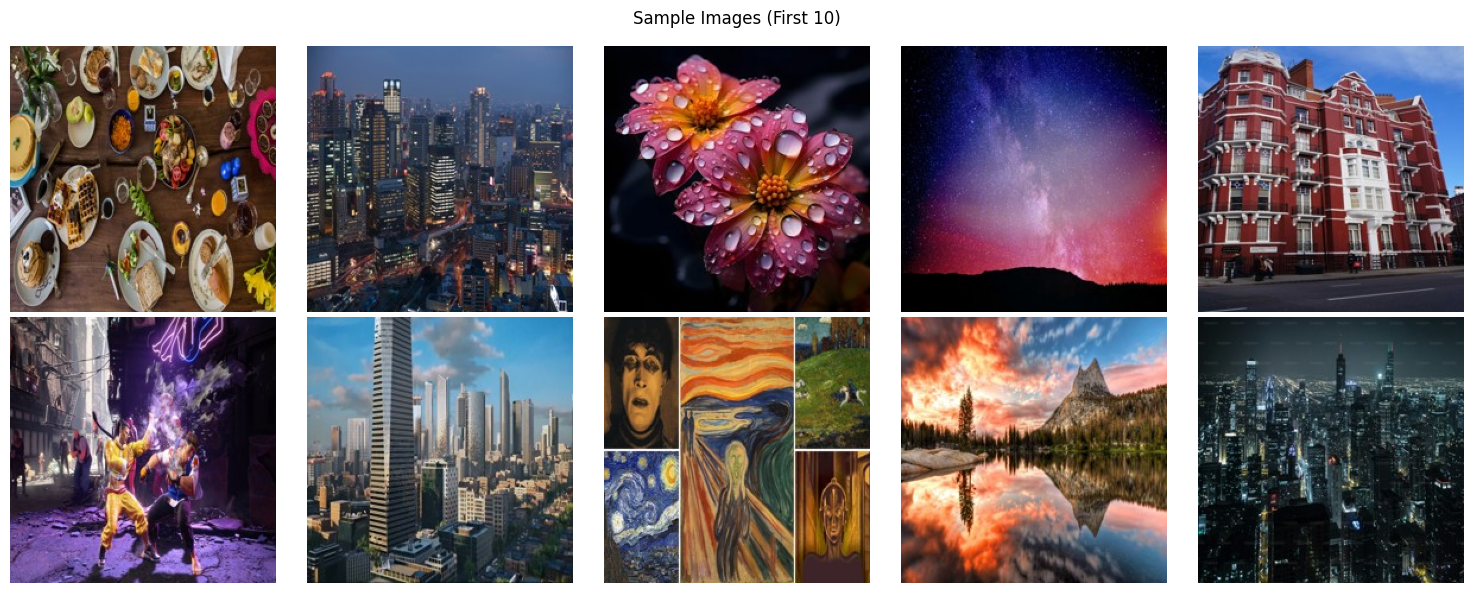

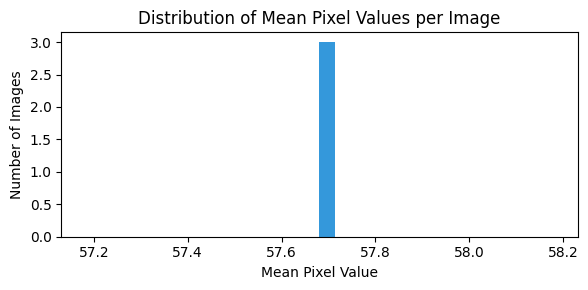


=== SAMPLE TEXTS ===
1. Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
2. Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
3. Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
4. Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.
5. Oil prices soar to all-time record, posing new menace to US e

In [ ]:
# --- Overview of the loaded dataset ---
import matplotlib.pyplot as plt
from math import ceil
import numpy as np

print("=== DATASET OVERVIEW ===")
print(f"- Raw image array shape: {x_data_original.shape}")
print(f"- Image feature vectors shape: {img_vectors.shape}")
print(f"- Text embeddings shape: {text_vectors.shape}")
print(f"- Number of sentences: {len(sentences)}")

# Basic statistics for image data
means = x_data_original.mean(axis=(1, 2, 0))
print(f"- Mean pixel value: {means.mean():.2f} ± {means.std():.2f}")
print(f"- Value range: [{x_data_original.min():.0f}, {x_data_original.max():.0f}]")

# Display 10 sample images
cols = 5
rows = ceil(10 / cols)
plt.figure(figsize=(cols * 3, rows * 3))
for i in range(10):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(x_data_original[i].astype("uint8"))
    plt.axis("off")
plt.suptitle("Sample Images (First 10)", fontsize=12)
plt.tight_layout()
plt.show()

# Histogram of mean pixel values per image
plt.figure(figsize=(6, 3))
plt.hist(means, bins=30, color="#3498db")
plt.title("Distribution of Mean Pixel Values per Image")
plt.xlabel("Mean Pixel Value")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

# Display a few sample text entries
print("\n=== SAMPLE TEXTS ===")
for i, s in enumerate(sentences[:10]):
    print(f"{i+1}. {s}")

# Clean data, overview cleaned data and load them to files


Cleaning and preprocessing the dataset...


Resizing: 100%|██████████| 1484/1484 [00:01<00:00, 793.61it/s]


- RGB resized shape: (1484, 224, 224, 3)
- Preprocessed shape: (1484, 224, 224, 3)
- Value range after preprocessing: [-123.68, 151.06]


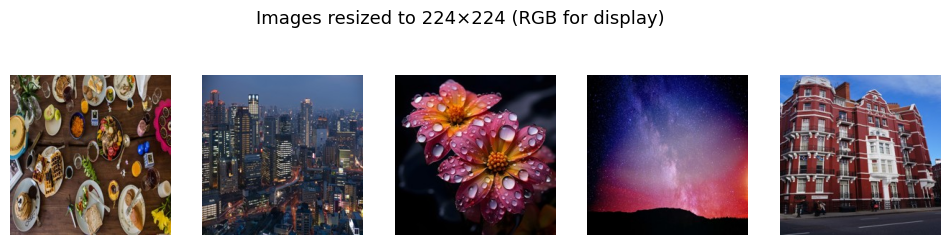

Saved x_data_original.npy, x_data_resized_rgb.npy, and x_data_preprocessed.npy


In [ ]:
# --- Step 2: Cleaning and Preprocessing ---
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

print("\nCleaning and preprocessing the dataset...")

# Keep a copy of the original dataset for visualization
x_data_original = x_data_original.copy()

# Resize all images to (224, 224) while maintaining RGB format
x_data_resized_rgb = np.array([
    image.smart_resize(img, (224, 224)) for img in tqdm(x_data_original, desc="Resizing")
])

# Apply ResNet preprocessing (convert RGB to BGR and normalize)
x_data_preprocessed = preprocess_input(x_data_resized_rgb.copy())

print(f"- RGB resized shape: {x_data_resized_rgb.shape}")
print(f"- Preprocessed shape: {x_data_preprocessed.shape}")
print(f"- Value range after preprocessing: [{x_data_preprocessed.min():.2f}, {x_data_preprocessed.max():.2f}]")

# Show a few sample images (RGB version, not preprocessed)
plt.figure(figsize=(12, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_data_resized_rgb[i].astype("uint8"))
    plt.axis('off')
plt.suptitle("Images resized to 224×224 (RGB for display)", fontsize=13)
plt.show()

# --- Save processed datasets ---
np.save("x_data_original.npy", x_data_original)
np.save("x_data_resized_rgb.npy", x_data_resized_rgb)
np.save("x_data_preprocessed.npy", x_data_preprocessed)
print("Saved x_data_original.npy, x_data_resized_rgb.npy, and x_data_preprocessed.npy")


Extracting image features using ResNet50 (pooling='avg')...
47/47 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step
- Feature vector shape: (1484, 2048)
- Data type: float32
- Mean of feature values: 0.4590 | Standard deviation: 0.8200


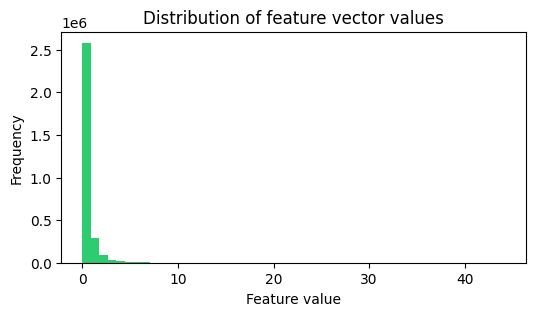


Saved x_data_original.npy and img_vectors.npy


In [ ]:
# --- Extracting features and summarizing the dataset ---
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50

print("\nExtracting image features using ResNet50 (pooling='avg')...")
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

img_vectors = resnet_model.predict(x_data_preprocessed, batch_size=32, verbose=1)

print(f"- Feature vector shape: {img_vectors.shape}")
print(f"- Data type: {img_vectors.dtype}")
print(f"- Mean of feature values: {img_vectors.mean():.4f} | Standard deviation: {img_vectors.std():.4f}")

plt.figure(figsize=(6, 3))
plt.hist(img_vectors.flatten(), bins=50, color="#2ecc71")
plt.title("Distribution of feature vector values")
plt.xlabel("Feature value")
plt.ylabel("Frequency")
plt.show()

# --- Save processed data ---
np.save("x_data_original.npy", x_data_original)
np.save("img_vectors.npy", img_vectors)
print("\nSaved x_data_original.npy and img_vectors.npy")

In [ ]:
x_data_original = np.load("x_data_original.npy")
img_vectors = np.load("img_vectors.npy")
sentences = np.load("sentences.npy", allow_pickle=True)
text_vectors = np.load("text_vectors.npy")

# Provide inputs

In [ ]:
# --- Query Input Section ---
from sentence_transformers import SentenceTransformer
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import files
import numpy as np

print("=== Query Mode Selection ===")
print("1. Search by image")
print("2. Search by text")

mode = input("Enter query option (1 or 2): ").strip()

if mode == "1":
    print("Please upload the query image:")
    uploaded = files.upload()
    img_path = list(uploaded.keys())[0]

    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = np.expand_dims(image.img_to_array(img), axis=0)
    img_array = preprocess_input(img_array)

    # Extract query features
    print("Extracting image features using ResNet50...")
    model_img = ResNet50(weights='imagenet', include_top=False, pooling='avg')
    query_vector = model_img.predict(img_array)

elif mode == "2":
    print("Text-based query mode selected.")
    query_text = input("Please enter the query text: ").strip()
    model_text = SentenceTransformer('paraphrase-MiniLM-L6-v2', device='cuda')
    query_vector = model_text.encode([query_text])

else:
    raise ValueError("Invalid option! Please enter 1 or 2.")

# Number of results
K = int(input("Enter the number of top results (K): "))
if K <= 0:
    raise ValueError("Invalid value for K! Must be positive.")

print(f"Query vector created successfully. Mode: {'Image' if mode=='1' else 'Text'}")
print(f"Top-{K} results will be retrieved.")

=== Query Mode Selection ===
1. Search by image
2. Search by text
Enter query option (1 or 2): 2
Text-based query mode selected.
Please enter the query text: I eat kids
Enter the number of top results (K): 50
Query vector created successfully. Mode: Text
Top-50 results will be retrieved.


# Brute-force linear searching

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import math

print("=== Brute-force Linear Search ===")

if mode == "1":  # Image search
    sims = cosine_similarity(query_vector, img_vectors)
    top_k_idx = np.argsort(-sims, axis=1)[0][:K]

    print(f"\nTop-{K} most similar images:")
    for i, idx in enumerate(top_k_idx):
        print(f"{i+1}. Index: {idx} | Cosine similarity: {sims[0][idx]:.4f}")

    # --- Visualization ---
    cols = 5  # number of images per row
    rows = math.ceil(K / cols)
    plt.figure(figsize=(cols * 3.2, rows * 3.2))
    for i, idx in enumerate(top_k_idx):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(x_data_resized_rgb[idx].astype("uint8"))
        plt.title(f"idx={idx}\nsim={sims[0][idx]:.2f}")
        plt.axis('off')

    plt.suptitle(f"Top-{K} most similar images (Linear Search)",
                 fontsize=14, fontweight='bold')

    # thêm khoảng cách giữa các ảnh
    plt.subplots_adjust(wspace=0.35, hspace=0.45)
    plt.show()

elif mode == "2":  # Text search
    sims = cosine_similarity(query_vector, text_vectors)
    top_k_idx = np.argsort(-sims, axis=1)[0][:K]

    print(f"\nTop-{K} most similar texts:")
    for i, idx in enumerate(top_k_idx):
        print(f"{i+1}. (score={sims[0][idx]:.4f}) {sentences[idx]}")

=== Brute-force Linear Search ===

Top-50 most similar texts:
1. (score=0.4017) Hungry world 'must eat less meat' People will need to eat more vegetables and less meat because of dwindling water supplies, scientists say.
2. (score=0.3966) Which Diet is Best? The One That Works for You By Kathleen Doheny, HealthDay Reporter    HealthDayNews -- Gather together some diners who are trying to lose weight, then sit back and listen to the debate.    Almost anyone who's on a diet -- or at least one that's working -- is convinced his or her plan is the best...
3. (score=0.3720) Study Says Birds Feed Other Birds' Young (AP) AP - It's a lesson many little humans could learn from baby birds: Sometimes, being nice to other youngsters pays off. Brown-headed cowbirds, like several other bird species, leave their eggs in the nests of other birds, who then feed and raise the cowbird chicks.
4. (score=0.3644) New Computer Games Teach Nutrition to Needy In an effort to educate the nation's neediest child

# Using scaNN

In [ ]:
import numpy as np
import scann
import matplotlib.pyplot as plt
import math

# --- Load saved data ---
print("Loading saved data files...")
x_data_original = np.load("x_data_original.npy")
img_vectors = np.load("img_vectors.npy")
sentences = np.load("sentences.npy", allow_pickle=True)
text_vectors = np.load("text_vectors.npy")

print(f"Loaded data: Images {img_vectors.shape} | Texts {text_vectors.shape}")

# --- Use existing mode and K from previous cell ---
print(f"\nCurrent mode: {'Images' if mode == '1' else 'Texts'} | Top-{K} results")

# --- Build ScaNN searcher ---
print("\nBuilding ScaNN index...")
searcher = (
    scann.scann_ops_pybind.builder(
        img_vectors if mode == "1" else text_vectors,
        K,
        "dot_product"
    )
    .tree(num_leaves=100, num_leaves_to_search=10, training_sample_size=2000)
    .score_brute_force()
    .build()
)

# --- Perform search ---
print("Performing ScaNN search...")
neighbors, distances = searcher.search_batched(query_vector, final_num_neighbors=K)
neighbors, distances = neighbors[0], distances[0]

# --- Display results ---
if mode == "1":
    print(f"\nTop-{K} most similar images:")
    cols = 5
    rows = math.ceil(K / cols)
    plt.figure(figsize=(cols * 3.2, rows * 3.2))  # tăng nhẹ kích thước
    for i, idx in enumerate(neighbors):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(x_data_resized_rgb[idx].astype("uint8"))
        plt.title(f"idx={idx}\nsim={distances[i]:.2f}")
        plt.axis("off")
    plt.suptitle(f"Top-{K} most similar images (ScaNN)", fontsize=14, fontweight="bold")
    # đặt đúng vị trí sau khi tạo subplot
    plt.subplots_adjust(wspace=0.35, hspace=0.45)
    plt.show()
else:
    print(f"\nTop-{K} most similar texts:")
    for i, (idx, dist) in enumerate(zip(neighbors, distances)):
        print(f"{i+1}. (score={dist:.4f}) {sentences[idx]}")

Loading saved data files...
Loaded data: Images (1484, 2048) | Texts (2000, 384)

Current mode: Texts | Top-50 results

Building ScaNN index...
Performing ScaNN search...

Top-50 most similar texts:
1. (score=18.3605) Hungry world 'must eat less meat' People will need to eat more vegetables and less meat because of dwindling water supplies, scientists say.
2. (score=16.1705) UN creates game to tackle hunger A forthcoming video game aims to educate children about the global fight against hunger.
3. (score=14.6788) New Computer Games Teach Nutrition to Needy In an effort to educate the nation's neediest children on nutrition, a new project uses the familiar medium of video games to broadcast its message. The Fantastic Food Challenge, a package of four computer games, is designed to teach people who get nutrition aid such as federal food stamps how to make better use of their food.
4. (score=13.3084) Study Says Birds Feed Other Birds' Young (AP) AP - It's a lesson many little humans could

 # Comparing performance of scaNN and linear searching

In [ ]:
import scann
import numpy as np
import time
from sklearn.metrics.pairwise import cosine_similarity

# --- Configuration ---
use_image = (mode == "1")   # True = image search, False = text search
vectors = img_vectors if use_image else text_vectors
data_type = "IMAGES" if use_image else "TEXT"

print(f"\n=== Performance Evaluation on {data_type} ===")
print(f"Number of samples: {len(vectors):,} | Vector dimension: {vectors.shape[1]} | Top-K = {K}\n")

# --- Random query selection ---
np.random.seed(42)
query_idx = np.random.randint(len(vectors))
query_vec = vectors[query_idx:query_idx + 1]

# =============================
# LINEAR SEARCH (Brute Force)
# =============================
start = time.time()
cos_sim = cosine_similarity(query_vec, vectors)[0]
linear_topK = np.argsort(-cos_sim)[:K]
linear_time = time.time() - start

# =============================
# ScaNN SEARCH
# =============================
searcher = scann.scann_ops_pybind.builder(vectors, K, "dot_product") \
    .tree(num_leaves=100, num_leaves_to_search=10, training_sample_size=2000) \
    .score_brute_force().build()

start = time.time()
neighbors, _ = searcher.search_batched(query_vec, final_num_neighbors=K)
scann_topK = neighbors[0]
scann_time = time.time() - start

# =============================
# RECALL@K
# =============================
recall_at_k = len(set(scann_topK) & set(linear_topK)) / K

# =============================
# MEMORY USAGE
# =============================
bytes_per_vector = vectors.nbytes / len(vectors)
total_MB = vectors.nbytes / (1024 * 1024)
scann_index_size_MB = total_MB * 1.05  # Estimate: +5% for ScaNN index structure

# =============================
# DETAILED RESULTS
# =============================
print("-----------------------------------------")
print(" LINEAR SEARCH:")
print(f"   - Time taken: {linear_time * 1000:.2f} ms")
print(f"   - Estimated memory usage: {total_MB:.2f} MB  ({bytes_per_vector / 1024:.2f} KB/vector)")
print(f"   - Accuracy: 100.00%")

print("\n ScaNN SEARCH:")
print(f"   - Time taken: {scann_time * 1000:.2f} ms")
print(f"   - Estimated memory usage: {scann_index_size_MB:.2f} MB")
print(f"   - Recall@{K}: {recall_at_k * 100:.1f}%")

# =============================
# SUMMARY COMPARISON
# =============================
speedup = linear_time / scann_time
memory_diff = ((scann_index_size_MB - total_MB) / total_MB) * 100

print("\n Summary Comparison:")
print(f"     ScaNN is {speedup:.2f}× faster than Linear Search")
print(f"     ScaNN memory usage is about {memory_diff:.1f}% higher")
print(f"     Accuracy drops to {recall_at_k * 100:.1f}% compared to Linear Search (100%)")
print("-----------------------------------------")


=== Performance Evaluation on TEXT ===
Number of samples: 2,000 | Vector dimension: 384 | Top-K = 50

-----------------------------------------
 LINEAR SEARCH:
   - Time taken: 5.45 ms
   - Estimated memory usage: 2.93 MB  (1.50 KB/vector)
   - Accuracy: 100.00%

 ScaNN SEARCH:
   - Time taken: 0.39 ms
   - Estimated memory usage: 3.08 MB
   - Recall@50: 82.0%

 Summary Comparison:
     ScaNN is 13.88× faster than Linear Search
     ScaNN memory usage is about 5.0% higher
     Accuracy drops to 82.0% compared to Linear Search (100%)
-----------------------------------------


# Visualization

Evaluating on TEXTS (2000 samples, 384 dimensions)
Using 50 random queries, Top-50

AVERAGE PERFORMANCE:
- Linear Search: 3.06 ms
- ScaNN: 0.10 ms
- Speedup: 31.8× faster
- Recall@50: 62.8%
- Memory usage: Linear = 2.93 MB | ScaNN ≈ 3.08 MB


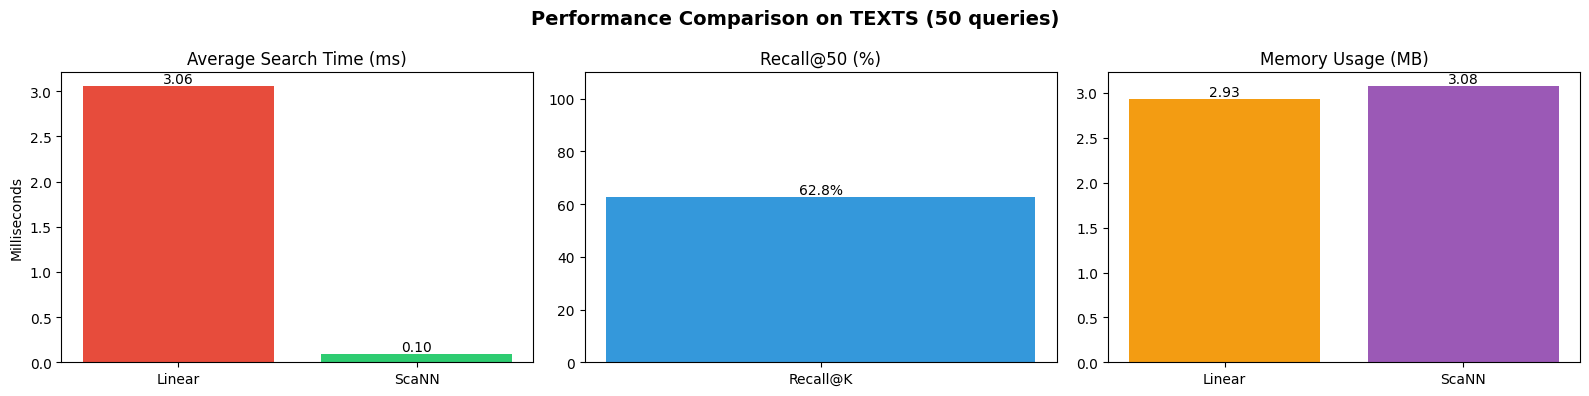


Overall Comparison:
   ScaNN is 31.81× faster than linear search
   ScaNN requires 5.0% more memory
   Average accuracy: 62.8% (Recall@50)


In [ ]:
import scann
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# --- Configuration ---
use_image = (mode == "1")  # True = images, False = texts
vectors = img_vectors if use_image else text_vectors
N_QUERY = 50  # number of random queries for average evaluation

print(f"Evaluating on {'IMAGES' if use_image else 'TEXTS'} "
      f"({len(vectors)} samples, {vectors.shape[1]} dimensions)")
print(f"Using {N_QUERY} random queries, Top-{K}")

# --- Build ScaNN searcher ---
searcher = scann.scann_ops_pybind.builder(vectors, K, "dot_product") \
    .tree(num_leaves=100, num_leaves_to_search=10, training_sample_size=2000) \
    .score_brute_force().build()

linear_times, scann_times, recalls = [], [], []

# --- Evaluate multiple queries ---
for _ in range(N_QUERY):
    idx = np.random.randint(len(vectors))
    query = vectors[idx:idx + 1]

    # Linear search
    t0 = time.time()
    cos_sim = cosine_similarity(query, vectors)[0]
    linear_topK = np.argsort(-cos_sim)[:K]
    linear_time = time.time() - t0

    # ScaNN search
    t1 = time.time()
    neighbors, _ = searcher.search_batched(query, final_num_neighbors=K)
    scann_topK = neighbors[0]
    scann_time = time.time() - t1

    # Recall@K
    recall = len(set(linear_topK) & set(scann_topK)) / K

    # Store results
    linear_times.append(linear_time)
    scann_times.append(scann_time)
    recalls.append(recall)

# --- Average results ---
avg_linear = np.mean(linear_times)
avg_scann = np.mean(scann_times)
avg_recall = np.mean(recalls)

# --- Memory estimation ---
bytes_per_vector = vectors.nbytes / len(vectors)
total_MB = vectors.nbytes / (1024 * 1024)
scann_MB = total_MB * 1.05  # estimate +5% overhead for ScaNN index

# --- Print results ---
print("\nAVERAGE PERFORMANCE:")
print(f"- Linear Search: {avg_linear * 1000:.2f} ms")
print(f"- ScaNN: {avg_scann * 1000:.2f} ms")
print(f"- Speedup: {avg_linear / avg_scann:.1f}× faster")
print(f"- Recall@{K}: {avg_recall * 100:.1f}%")
print(f"- Memory usage: Linear = {total_MB:.2f} MB | ScaNN ≈ {scann_MB:.2f} MB")

# --- Visualization ---
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

# Average search time
ax[0].bar(["Linear", "ScaNN"], [avg_linear * 1000, avg_scann * 1000],
          color=["#e74c3c", "#2ecc71"])
ax[0].set_title("Average Search Time (ms)")
ax[0].set_ylabel("Milliseconds")
ax[0].text(0, avg_linear * 1000, f"{avg_linear * 1000:.2f}", ha='center', va='bottom')
ax[0].text(1, avg_scann * 1000, f"{avg_scann * 1000:.2f}", ha='center', va='bottom')

# Recall@K
ax[1].bar(["Recall@K"], [avg_recall * 100], color="#3498db")
ax[1].set_ylim(0, 110)
ax[1].set_title(f"Recall@{K} (%)")
ax[1].text(0, avg_recall * 100, f"{avg_recall * 100:.1f}%", ha='center', va='bottom')

# Memory usage
ax[2].bar(["Linear", "ScaNN"], [total_MB, scann_MB],
          color=["#f39c12", "#9b59b6"])
ax[2].set_title("Memory Usage (MB)")
ax[2].text(0, total_MB, f"{total_MB:.2f}", ha='center', va='bottom')
ax[2].text(1, scann_MB, f"{scann_MB:.2f}", ha='center', va='bottom')

plt.suptitle(f"Performance Comparison on {'IMAGES' if use_image else 'TEXTS'} "
             f"({N_QUERY} queries)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# --- Summary ---
print("\nOverall Comparison:")
print(f"   ScaNN is {avg_linear / avg_scann:.2f}× faster than linear search")
print(f"   ScaNN requires {(scann_MB - total_MB) / total_MB * 100:.1f}% more memory")
print(f"   Average accuracy: {avg_recall * 100:.1f}% (Recall@{K})")